In [219]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, fbeta_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tsa.arima.model import ARIMA 
from tqdm import tqdm
import copy

import warnings
warnings.filterwarnings("ignore")

In [220]:
torch.manual_seed(42)  # Настройка воспроизводимости
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [292]:
from pathlib import Path

# Определяем список всех необходимых директорий
required_dirs = [
    "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Metrics",
    "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/Multiclass",
    "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/Binary",
    "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/RUL",
    "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Plots"
]

# Создаем каждую директорию, если она не существует
for dir_path in required_dirs:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

## Data Ingestion

In [221]:
# # Загрузка всех таблиц
# telemetry = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_telemetry.csv")
# errors = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_errors.csv")
# maint = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_maint.csv")
# failures = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_failures.csv")
# machines = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_machines.csv")

In [222]:
# Загрузка всех таблиц
telemetry = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_telemetry.csv")
errors = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_errors.csv")
maint = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_maint.csv")
failures = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_failures.csv")
machines = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_machines.csv")

In [223]:
# Преобразование даты
for df in [telemetry, errors, maint, failures]:
    df["datetime"] = pd.to_datetime(df["datetime"])

In [224]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [225]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


errorID
error1    1010
error2     988
error3     838
error4     727
error5     356
Name: count, dtype: int64

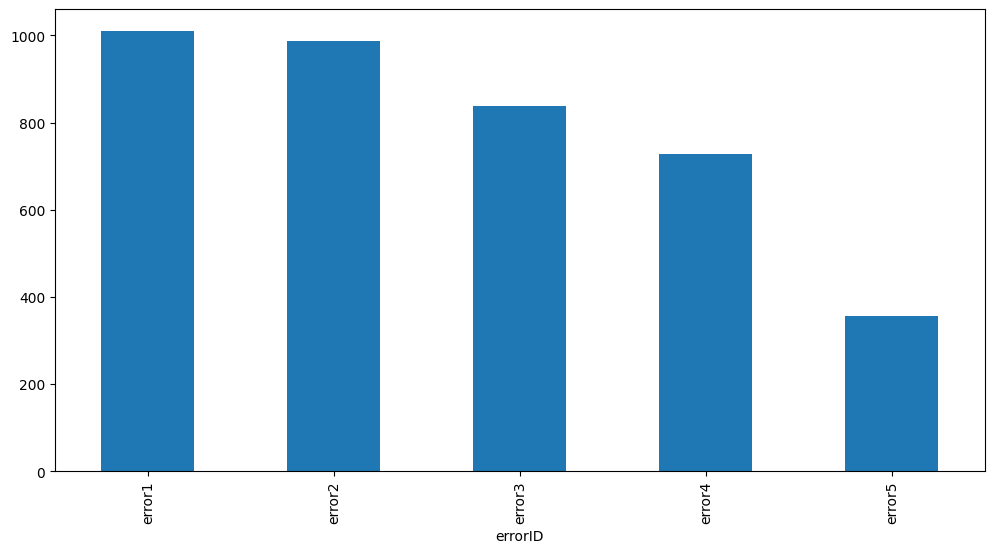

In [226]:
plt.figure(figsize=(12, 6))
errors["errorID"].value_counts().plot(kind="bar")
errors["errorID"].value_counts()

In [227]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


comp
comp2    863
comp4    811
comp3    808
comp1    804
Name: count, dtype: int64

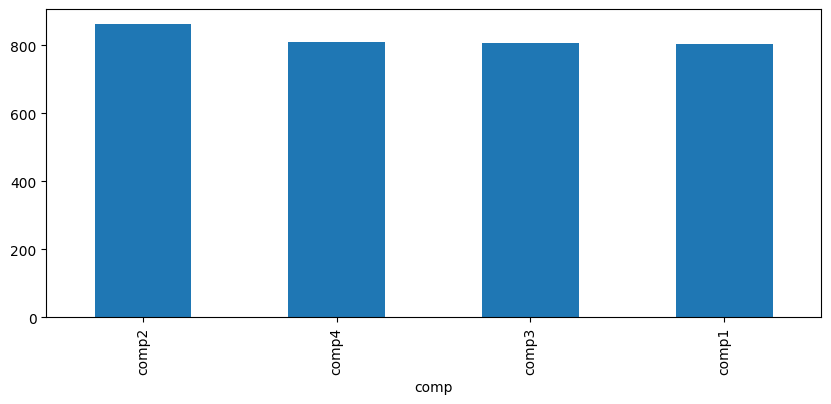

In [228]:
plt.figure(figsize=(10, 4))
maint["comp"].value_counts().plot(kind="bar")
maint["comp"].value_counts()

In [229]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


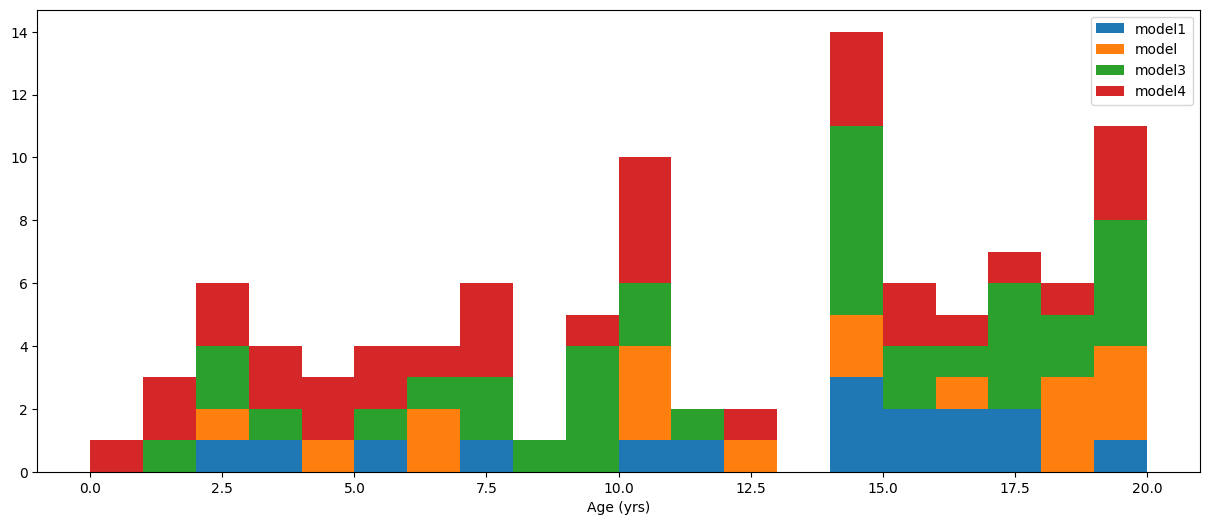

In [230]:
plt.figure(figsize=(15, 6))
_, bins, _ = plt.hist([machines.loc[machines["model"] == "model1", "age"],
                       machines.loc[machines["model"] == "model2", "age"],
                       machines.loc[machines["model"] == "model3", "age"],
                       machines.loc[machines["model"] == "model4", "age"]],
                       20, stacked=True, label=["model1", "model", "model3", "model4"])
plt.xlabel("Age (yrs)")
plt.legend()

In [231]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


failure
comp2    259
comp1    192
comp4    179
comp3    131
Name: count, dtype: int64

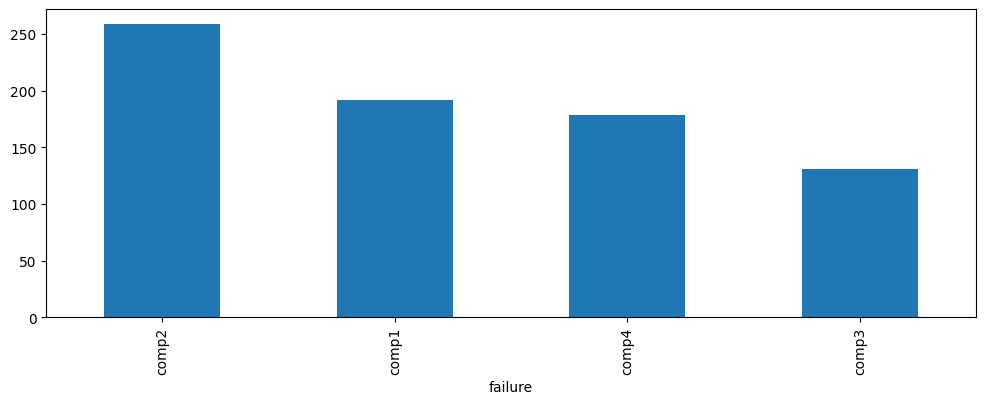

In [232]:
plt.figure(figsize=(12, 4))
failures["failure"].value_counts().plot(kind="bar")
failures["failure"].value_counts()

## Data Preprocessing

Примечание: 

Этот датасет не содержит пропусков, поэтому этап импутации (LSTM encoder-decoder) можно опустить. 

Скользящие средние и STD (3h и 24h).

In [233]:
# Список признаков
fields = ["volt", "rotate", "pressure", "vibration"]

def create_telemetry_features(telemetry):
    telemetry = telemetry.sort_values(["machineID", "datetime"])
    telemetry["datetime_3h"] = telemetry["datetime"].dt.floor("3H")
    
    # 3h aggregates
    agg_3h = telemetry.groupby(["machineID", "datetime_3h"])[fields].agg(["mean", "std"]).reset_index()
    agg_3h.columns = ["machineID", "datetime"] + [f"{f}{s}_3h" for f in fields for s in ["mean", "sd"]]
    
    # 24h rolling (на основе часовых данных)
    telemetry_wide = telemetry.set_index("datetime")
    agg_24h_list = []
    for mid, group in telemetry_wide.groupby("machineID"):
        for f in fields:
            group[f + "mean_24h"] = group[f].rolling("24H", min_periods=1).mean()
            group[f + "sd_24h"] = group[f].rolling("24H", min_periods=1).std()
        agg_24h_list.append(group[["machineID"] + [f + "mean_24h" for f in fields] + [f + "sd_24h" for f in fields]].reset_index())
    
    agg_24h = pd.concat(agg_24h_list, ignore_index=True)
    agg_24h = agg_24h.dropna()
    
    # Объединение
    feat = agg_3h.merge(agg_24h, on=["machineID", "datetime"], how="inner")
    return feat

Исследуем различные методы сглаживания для одного телеметрического признака.

In [234]:
# Выбираем машину и период
machine_id = 1
start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2015-02-01")

plot_df = telemetry.loc[
    (telemetry["machineID"] == machine_id) &
    (telemetry["datetime"] >= start_date) &
    (telemetry["datetime"] <= end_date)
].copy().sort_values("datetime")

print(f"Data: {len(plot_df)} dots (hr)")

Data: 739 dots (hr)


In [235]:
# Скользящее среднее и STD за 24 часа
plot_df = plot_df.set_index("datetime")
plot_df["volt_rolling_mean"] = plot_df["volt"].rolling(window=24, min_periods=1).mean()
plot_df["volt_rolling_std"] = plot_df["volt"].rolling(window=24, min_periods=1).std()
plot_df = plot_df.reset_index()

In [236]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Применяем Holt-Winters с аддитивным трендом и сезонностью
hw_model = ExponentialSmoothing(
    plot_df["volt"],
    trend="add",
    seasonal="add",
    seasonal_periods=24  # Дневная сезонность (24 часа)
).fit()

plot_df["volt_holt_winters"] = hw_model.fittedvalues

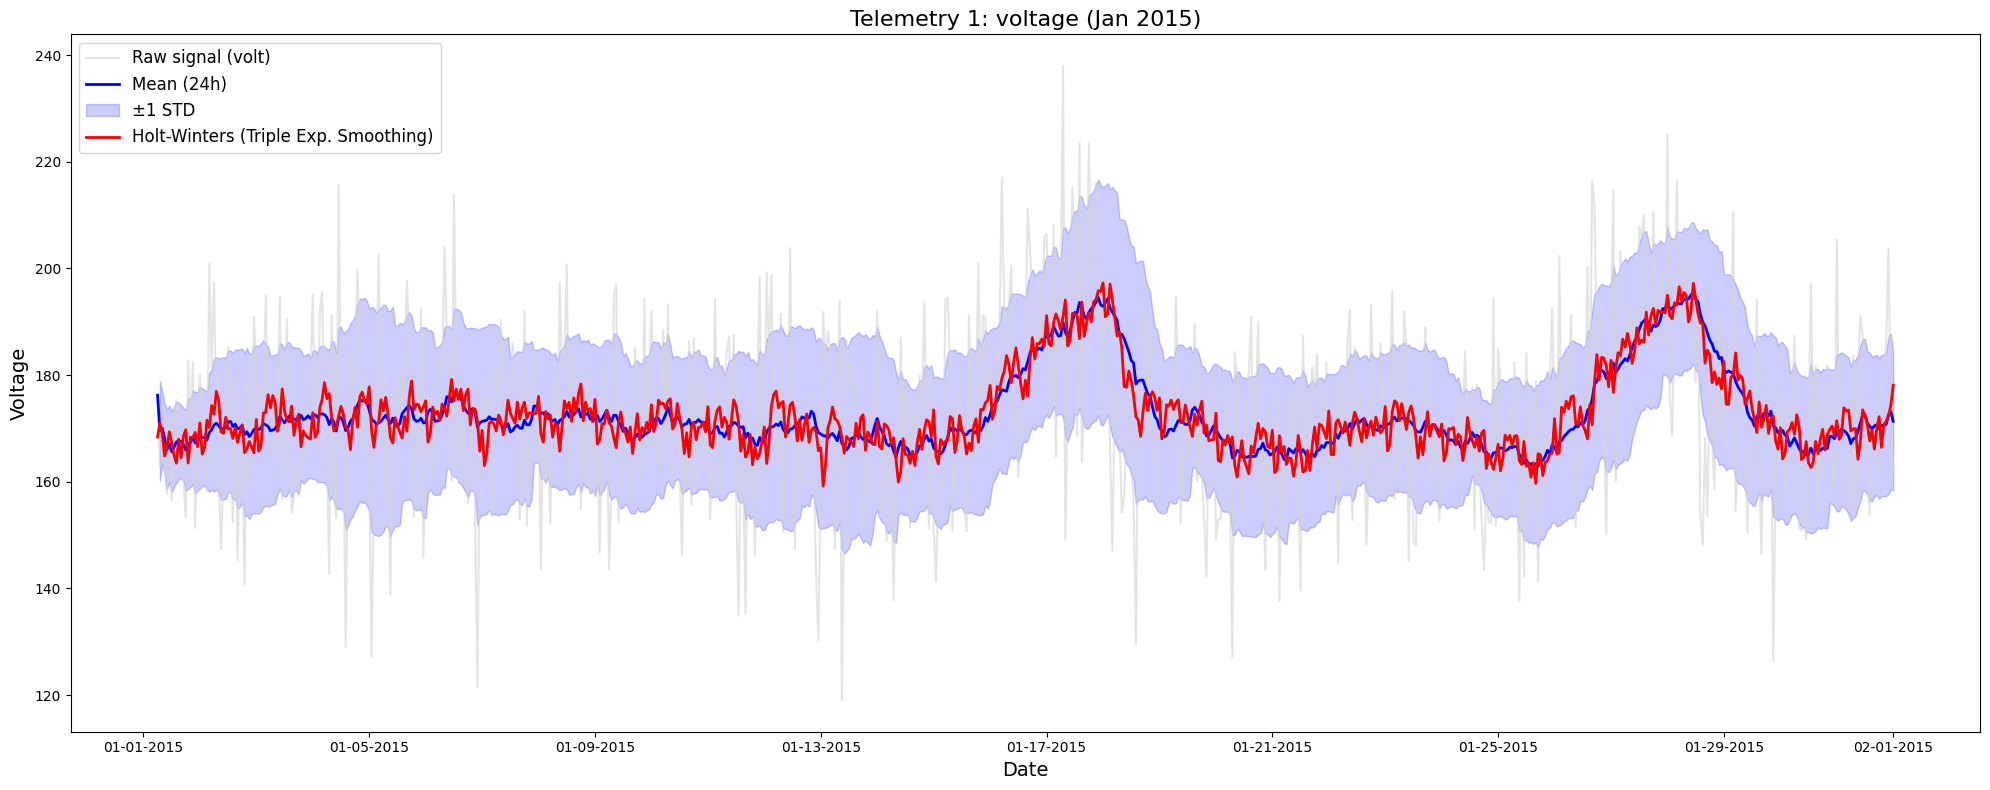

In [237]:
plt.figure(figsize=(20, 8))

# Исходные данные
plt.plot(plot_df["datetime"], plot_df["volt"], 
         label="Raw signal (volt)", 
         alpha=0.6, color="lightgray")

# Скользящее среднее
plt.plot(plot_df["datetime"], plot_df["volt_rolling_mean"], 
         label="Mean (24h)", 
         color="blue", linewidth=2)

# Доверительный интервал на основе STD
plt.fill_between(
    plot_df["datetime"],
    plot_df["volt_rolling_mean"] - plot_df["volt_rolling_std"],
    plot_df["volt_rolling_mean"] + plot_df["volt_rolling_std"],
    color="blue", alpha=0.2, label="±1 STD"
)

# Holt-Winters
plt.plot(plot_df["datetime"], plot_df["volt_holt_winters"], 
         label="Holt-Winters (Triple Exp. Smoothing)", 
         color="red", linewidth=2)

# Настройки
plt.title(f"Telemetry {machine_id}: voltage (Jan 2015)", fontsize=16)
plt.ylabel("Voltage", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.legend(fontsize=12)

# Формат даты на оси X
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = "%m-%d-%Y"

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Residuals Holt-Winters')

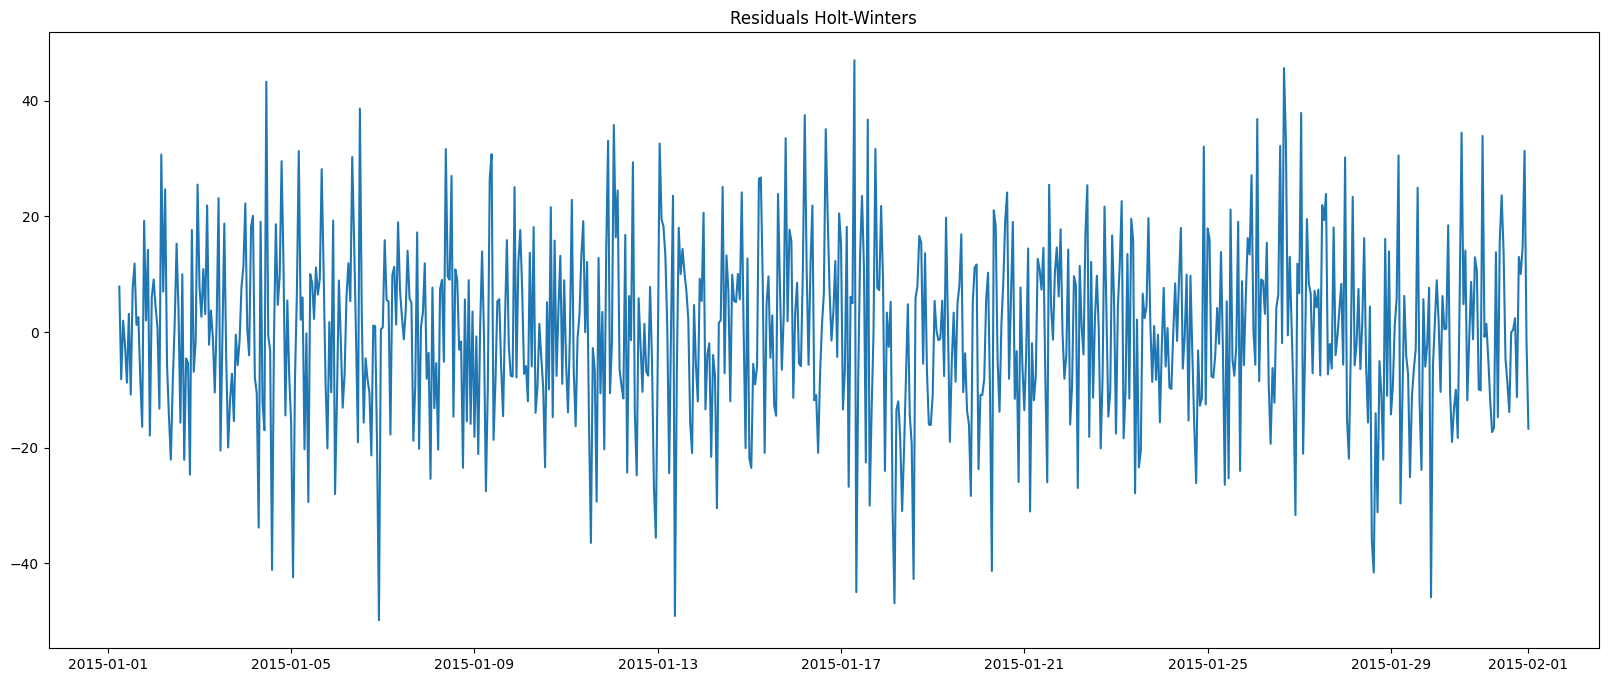

In [238]:
residuals = plot_df["volt"] - plot_df["volt_holt_winters"]  # Остатки

plt.figure(figsize=(20, 8))
plt.plot(plot_df["datetime"], residuals)
plt.title("Residuals Holt-Winters")

In [239]:
# Объединение всех признаков
telemetry_feat = create_telemetry_features(telemetry)

# Удаляем оставшиеся NaN 
telemetry_feat = telemetry_feat.dropna()

telemetry_feat.describe()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,291900.000000,291900,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000
mean,50.500000,2015-07-02 18:00:00,170.776678,13.299218,446.607287,44.456528,100.857847,8.885909,40.384977,4.441110,170.776977,446.605840,100.858037,40.384634,14.916891,49.947114,10.046691,5.002247
min,1.000000,2015-01-01 09:00:00,125.532506,0.025509,211.811184,0.078991,72.118639,0.027417,26.569635,0.015278,154.022949,266.010419,84.563174,31.883282,2.495533,12.026460,1.619279,0.896217
25%,25.750000,2015-04-02 12:00:00,164.449167,8.027362,427.563180,26.903705,96.238627,5.370368,38.147883,2.684815,168.070558,441.539601,98.667943,39.353304,13.356554,44.663514,8.923512,4.460112
50%,50.500000,2015-07-02 18:00:00,170.434378,12.495658,448.383875,41.795915,100.234191,8.345785,40.145826,4.173898,170.211969,449.210851,100.098210,40.072717,14.852678,49.612699,9.921354,4.958619
75%,75.250000,2015-10-02 00:00:00,176.610611,17.688527,468.447680,59.104130,104.406034,11.790303,42.227517,5.899848,172.462699,456.369633,101.613240,40.833986,16.394477,54.825097,10.981117,5.485186
max,100.000000,2016-01-01 03:00:00,241.420717,58.444332,586.682904,179.903039,162.309656,35.659369,69.311324,18.305595,220.782618,513.761534,152.310351,61.932124,32.696413,121.544102,28.654103,13.203534
std,28.866119,NaN,9.500328,6.966039,33.129628,23.215960,7.412819,4.656252,3.478683,2.320309,4.728555,18.095457,4.744648,2.062891,2.265301,7.699836,1.716655,0.801680


In [240]:
telemetry_feat.head()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
0,1,2015-01-01 09:00:00,164.192565,7.596570,403.949857,50.120452,105.687417,8.555032,34.255891,7.662229,168.137453,423.687682,98.256232,40.950662,6.665324,75.770259,17.109194,4.798255
1,1,2015-01-01 12:00:00,168.134445,10.124584,435.781707,55.084734,107.793709,5.909721,41.239405,5.169304,165.602958,437.074655,101.799186,38.314585,7.663161,60.321814,13.926919,6.776542
2,1,2015-01-01 15:00:00,165.514453,4.673269,430.472823,42.047278,101.703289,4.554047,40.373739,2.106108,167.628643,432.864675,102.906797,38.906813,7.201655,52.122115,11.734582,6.091345
3,1,2015-01-01 18:00:00,168.809347,14.752132,437.111120,47.048609,90.911060,4.244158,41.738542,2.207884,165.920374,434.606729,101.180158,39.568936,7.567359,50.433677,11.284286,5.550047
4,1,2015-01-01 21:00:00,168.779396,15.901952,486.242664,36.129552,90.446472,4.310741,41.796657,9.390494,168.281657,435.779180,99.239088,40.407795,8.847319,49.216633,11.038620,5.731789


Добавление Trend Features.

In [241]:
# Уже есть: telemetry_mean_3h, telemetry_mean_24h
# Создадим признаки тренда: разница между 24h и 3h средними

for col in fields:
    short_mean = f"{col}mean_3h"
    long_mean = f"{col}mean_24h"
    trend_col = f"{col}_trend"
    telemetry_feat[trend_col] = telemetry_feat[long_mean] - telemetry_feat[short_mean]

    # Аналогично для стандартного отклонения
    short_std = f"{col}sd_3h"
    long_std = f"{col}sd_24h"
    trend_std_col = f"{col}_trend_sd"
    telemetry_feat[trend_std_col] = telemetry_feat[long_std] - telemetry_feat[short_std]

Добавление FFT Features.

In [242]:
from scipy.fft import rfft, rfftfreq

def compute_fft_features(signal, n_peaks=2):
    N = len(signal)
    if N < 2:
        return np.zeros(2 * n_peaks)
    
    # Убираем DC-компонент (среднее)
    signal = signal - np.mean(signal)
    yf = np.abs(rfft(signal))
    xf = rfftfreq(N, d=1.0)  # Шаг = 1 (условные единицы)
    
    # Находим индексы топ-n пиков
    peak_indices = np.argsort(yf)[-n_peaks:][::-1]
    top_freqs = xf[peak_indices]
    top_amps = yf[peak_indices]
    
    # Конкатенируем и обрезаем/дополняем до 2 * n_peaks
    result = np.concatenate([top_freqs, top_amps])
    if len(result) < 2 * n_peaks:
        result = np.pad(result, (0, 2 * n_peaks - len(result)), constant_values=0)
    elif len(result) > 2 * n_peaks:
        result = result[:2 * n_peaks]

    return result

# Добавляем FFT-признаки
fft_features_list = []
window_size = 24  # Последние 24 записи (~24 ч)

for mid in telemetry["machineID"].unique():
    sub = telemetry[telemetry["machineID"] == mid].copy()
    sub = sub.sort_values("datetime")
    
    for i in range(window_size, len(sub) + 1):
        window = sub.iloc[i - window_size:i]
        row = {"machineID": mid, "datetime": window["datetime"].iloc[-1]}
        
        for col in fields:
            signal = window[col].values
            fft_vals = compute_fft_features(signal, n_peaks=2)
            for j in range(len(fft_vals)):
                row[f"{col}_fft{j}"] = fft_vals[j]
        
        fft_features_list.append(row)

# Создаём датафрейм и объединяем
fft_df = pd.DataFrame(fft_features_list)
telemetry_feat = telemetry_feat.merge(fft_df, on=["machineID", "datetime"], how="left")
telemetry_feat = telemetry_feat.fillna(0)  

In [243]:
# Найдём все FFT-колонки
fft_cols = [col for col in telemetry_feat.columns if 'fft' in col]

# Нормализация FFT-признаков
scaler_fft = StandardScaler()
telemetry_feat[fft_cols] = scaler_fft.fit_transform(telemetry_feat[fft_cols])

 Это гарантирует, что FFT-признаки имеют среднее ≈ 0 и std ≈ 1, как и исходные признаки (mean_3h, sd_24h и т.д.).

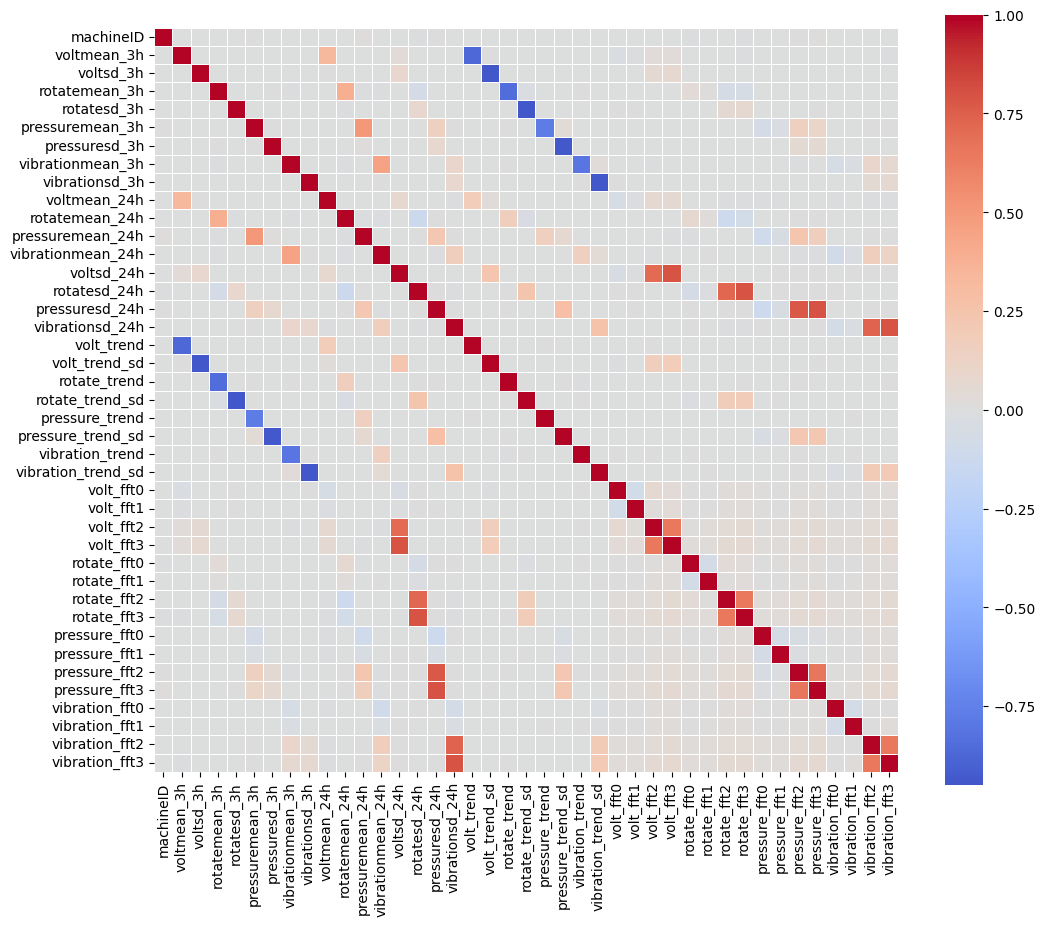

In [244]:
# Визуализация корреляции (для отладки)
plt.figure(figsize=(12, 10))
sns.heatmap(telemetry_feat.select_dtypes(include=[np.number]).corr(), 
            cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.show()

Признаки действительно слабо коррелируют, так как telemetry_feat включает разные физические величины. Но проверить стоило. 

Создаем подсчет ошибок за последние 24h.

In [245]:
# Убедимся, что у нас есть machineID и datetime
errors["datetime"] = pd.to_datetime(errors["datetime"])
errors["datetime_3h"] = errors["datetime"].dt.floor("3H")

# Преобразуем errorID в числовые метки
errors["errorID"] = errors["errorID"].str.replace("error", "").astype(int)

# Создаём one-hot кодирование
error_dummies = pd.get_dummies(errors, columns=["errorID"], prefix="error")

# Группируем по machineID и 3-часовому времени, суммируя только числовые колонки (ошибки)
# Исключаем исходные нечисловые колонки (datetime, errorID)
id_cols = ["machineID", "datetime_3h"]
error_cols = [col for col in error_dummies.columns if col.startswith("error_")]

# Агрегируем по machineID и усреднённому времени
error_grouped = error_dummies.groupby(id_cols)[error_cols].sum().reset_index()

# Создаём 24H скользящее окно (8 окон по 3 ч)
# Для этого сначала сделаем pivot, чтобы применить rolling
temp = []
for col in error_cols:
    # Поворачиваем таблицу: строки = datetime_3h, колонки = machineID
    pt = pd.pivot_table(
        error_grouped,
        index="datetime_3h",
        columns="machineID",
        values=col,
        fill_value=0
    )
    # Скользящая сумма за 24 часа 
    rolling_sum = pt.rolling(window=8, min_periods=1).sum()
    # Ресемплируем каждые 3 часа 
    # Берём первое значение (оно же единственное) в каждом 3H интервале
    resampled = rolling_sum.resample("3H", closed="left", label="right").first()
    # Возвращаем в длинный формат
    temp.append(resampled.unstack())

# Объединяем все типы ошибок
error_count = pd.concat(temp, axis=1)
error_count.columns = [f"error{i}count" for i in range(1, 6)]

# Сбрасываем индекс, чтобы machineID и datetime стали колонками
error_count = error_count.reset_index()
error_count.rename(columns={"datetime_3h": "datetime"}, inplace=True)

# Удаляем строки, где нет данных 
error_count = error_count.dropna()

error_count.describe()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
count,195400.000000,195400,195400.000000,195400.000000,195400.000000,195400.000000,195400.000000
mean,50.500000,2015-07-02 11:45:32.241555712,0.041351,0.040409,0.034186,0.029724,0.014575
min,1.000000,2015-01-01 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-03-31 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,2015-07-02 19:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,2015-10-01 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2016-01-01 06:00:00,2.000000,3.000000,2.000000,2.000000,2.000000
std,28.866144,NaN,0.202971,0.200702,0.184835,0.171951,0.120823


In [246]:
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
0,1,2015-01-01 09:00:00,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-01 15:00:00,0.0,0.0,0.0,0.0,0.0
4,1,2015-01-01 21:00:00,0.0,0.0,0.0,0.0,0.0
6,1,2015-01-02 03:00:00,0.0,0.0,0.0,0.0,0.0


Вычисляем дни с последней замены для каждого компонента.

In [247]:
# Подготовка maint
comp_rep = pd.get_dummies(maint.set_index("datetime")).reset_index()
comp_rep.columns = ["datetime", "machineID", "comp1", "comp2", "comp3", "comp4"]

# Агрегируем по machineID и datetime
comp_rep  = comp_rep.groupby(["machineID", "datetime"]).sum().reset_index()

# Добавляем временные точки, где не было замен
comp_rep = telemetry[["datetime", "machineID"]].merge(comp_rep,
                                                      on=["datetime", "machineID"],
                                                      how="outer").fillna(0).sort_values(by=["machineID", "datetime"])  # Сортируем по машине и времени 

comp_cols = ["comp1", "comp2", "comp3", "comp4"]
for comp in comp_cols:
    # Создаём бинарный флаг: была ли замена?
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
    
    # Заполняем с датой последней замены компонента (по машинам)
    comp_rep[comp] = comp_rep[comp].fillna(method="ffill")

# Удаляем данные до 2015 года
comp_rep = comp_rep[comp_rep["datetime"] >= pd.to_datetime("2015-01-01")].reset_index(drop=True)
for comp in comp_cols:
    comp_rep[comp] = (comp_rep["datetime"] - comp_rep[comp]) / np.timedelta64(1, "D")

comp_rep.describe()

,datetime,machineID,comp1,comp2,comp3,comp4
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,53.525185,51.540806,52.725962,53.834191
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,13.291667,12.125000,13.125000,13.000000
50%,2015-07-02 18:00:00,50.500000,32.791667,29.666667,32.291667,32.500000
75%,2015-10-02 00:00:00,75.250000,68.708333,66.541667,67.333333,70.458333
max,2016-01-01 06:00:00,100.000000,491.958333,348.958333,370.958333,394.958333
std,NaN,28.866087,62.491679,59.269254,58.873114,59.707978


In [248]:
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


In [249]:
# Слияние
final_feat = telemetry_feat.merge(error_count, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(comp_rep, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(machines, on="machineID", how="left")
final_feat = final_feat.fillna(0)

# One-hot кодирование 
final_feat = pd.get_dummies(final_feat, columns=["model"], prefix="model")
final_feat.describe()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,291900.000000,291900,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,...,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000
mean,50.500000,2015-07-02 18:00:00,170.776678,13.299218,446.607287,44.456528,100.857847,8.885909,40.384977,4.441110,...,0.027670,0.027044,0.022867,0.019887,0.009753,53.469000,51.477503,52.664745,53.772467,11.330000
min,1.000000,2015-01-01 09:00:00,125.532506,0.025509,211.811184,0.078991,72.118639,0.027417,26.569635,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-04-02 12:00:00,164.449167,8.027362,427.563180,26.903705,96.238627,5.370368,38.147883,2.684815,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.125000,13.125000,13.000000,6.750000
50%,50.500000,2015-07-02 18:00:00,170.434378,12.495658,448.383875,41.795915,100.234191,8.345785,40.145826,4.173898,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.625000,32.250000,32.500000,12.000000
75%,75.250000,2015-10-02 00:00:00,176.610611,17.688527,468.447680,59.104130,104.406034,11.790303,42.227517,5.899848,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,66.500000,67.250000,70.375000,16.000000
max,100.000000,2016-01-01 03:00:00,241.420717,58.444332,586.682904,179.903039,162.309656,35.659369,69.311324,18.305595,...,2.000000,3.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.866119,NaN,9.500328,6.966039,33.129628,23.215960,7.412819,4.656252,3.478683,2.320309,...,0.167172,0.165286,0.152026,0.141344,0.099075,62.484891,59.255134,58.862269,59.697678,5.827625


In [250]:
final_feat.head()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,...,error5count,comp1,comp2,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4
0,1,2015-01-01 09:00:00,164.192565,7.596570,403.949857,50.120452,105.687417,8.555032,34.255891,7.662229,...,0.0,19.125,214.125,154.125,169.125,18,False,False,True,False
1,1,2015-01-01 12:00:00,168.134445,10.124584,435.781707,55.084734,107.793709,5.909721,41.239405,5.169304,...,0.0,19.250,214.250,154.250,169.250,18,False,False,True,False
2,1,2015-01-01 15:00:00,165.514453,4.673269,430.472823,42.047278,101.703289,4.554047,40.373739,2.106108,...,0.0,19.375,214.375,154.375,169.375,18,False,False,True,False
3,1,2015-01-01 18:00:00,168.809347,14.752132,437.111120,47.048609,90.911060,4.244158,41.738542,2.207884,...,0.0,19.500,214.500,154.500,169.500,18,False,False,True,False
4,1,2015-01-01 21:00:00,168.779396,15.901952,486.242664,36.129552,90.446472,4.310741,41.796657,9.390494,...,0.0,19.625,214.625,154.625,169.625,18,False,False,True,False


In [251]:
# Сортировка и объединение отказов с признаками по времени
failures["datetime"] = pd.to_datetime(failures["datetime"])
failures = failures.sort_values(["machineID", "datetime"])

# Список всех отказов
failure_records = []

for _, row in failures.iterrows():
    mid = row["machineID"]
    t_fail = row["datetime"]
    comp = row["failure"]
    
    # Выбираем признаки за 24 часа до отказа
    window_start = t_fail - pd.Timedelta(hours=24)
    window_features = final_feat[
        (final_feat["machineID"] == mid) &
        (final_feat["datetime"] >= window_start) &
        (final_feat["datetime"] < t_fail)
    ].copy()
    
    # Каждая строка в окне отдельный объект с меткой отказа
    window_features["failure"] = comp
    failure_records.append(window_features)

# Объединяем все положительные окна
positive_samples = pd.concat(failure_records, ignore_index=True)

# Добавляем случайные отрицательные примеры без отказа
# Сначала определим все временные точки, где нет отказа в будущем 24h
all_times = final_feat[["machineID", "datetime"]].copy()
all_times = all_times.merge(failures, on=["machineID", "datetime"], how="left")
all_times = all_times[all_times["failure"].isna()]  # Нет отказа именно в этот момент

# Убираем точки, где в следующие 24h есть отказ
def has_failure_in_next_24h(row, failures_df):
    t = row["datetime"]
    mid = row["machineID"]
    future_fails = failures_df[
        (failures_df["machineID"] == mid) &
        (failures_df["datetime"] > t) &
        (failures_df["datetime"] <= t + pd.Timedelta(hours=24))
    ]
    return not future_fails.empty

all_times["has_future_fail"] = all_times.apply(
    lambda r: has_failure_in_next_24h(r, failures), axis=1
)
negative_candidates = all_times[~all_times["has_future_fail"]]

# Выбираем случайные точки 
# Например, в 10 раз больше, чем положительных
n_pos = len(positive_samples)
n_neg = min(10 * n_pos, len(negative_candidates))
negative_samples = negative_candidates.sample(n=n_neg, random_state=42).copy()
negative_samples = negative_samples.merge(final_feat, on=["machineID", "datetime"], how="left")
negative_samples["failure"] = "none"

# Объединяем
labeled_features_clean = pd.concat([positive_samples, negative_samples], ignore_index=True)
labeled_features = labeled_features_clean.dropna(subset=["failure"])
labeled_features.head()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,...,comp2,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4,failure,has_future_fail
0,1,2015-01-04 06:00:00,166.281848,24.276228,453.787824,23.621315,106.187582,11.176731,51.990080,3.394073,...,217.000,157.000,172.000,18,False,False,True,False,comp4,NaN
1,1,2015-01-04 09:00:00,175.412103,34.918687,445.450581,11.001625,100.887363,10.580336,54.251534,2.921501,...,217.125,157.125,172.125,18,False,False,True,False,comp4,NaN
2,1,2015-01-04 12:00:00,157.347716,24.617739,451.882075,28.950883,101.289380,9.966729,48.602686,2.356486,...,217.250,157.250,172.250,18,False,False,True,False,comp4,NaN
3,1,2015-01-04 15:00:00,176.450550,8.071400,446.033068,76.511343,84.521555,2.636879,47.638836,4.108621,...,217.375,157.375,172.375,18,False,False,True,False,comp4,NaN
4,1,2015-01-04 18:00:00,190.325814,8.390777,422.692565,7.176553,107.393234,4.262645,49.552856,7.598552,...,217.500,157.500,172.500,18,False,False,True,False,comp4,NaN


In [252]:
print("Positive samples (failures):", len(positive_samples))
print("Negative samples (none):", len(negative_samples))

Positive samples (failures): 6049
Negative samples (none): 60490


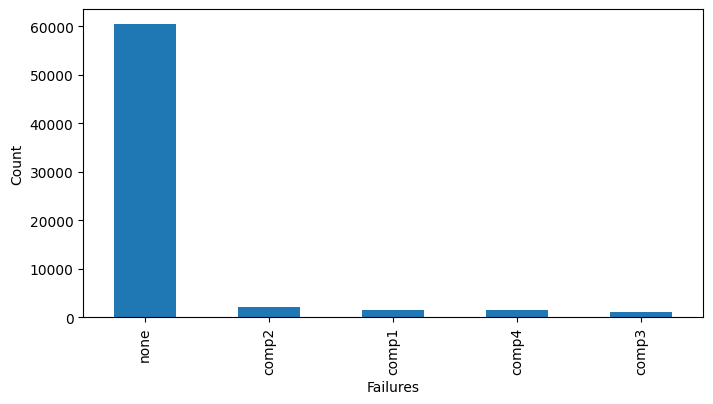

In [253]:
plt.figure(figsize=(8, 4))
labeled_features["failure"].value_counts().plot(kind="bar")  # Визуализация дисбаланса
plt.xlabel("Failures")
plt.ylabel("Count")
plt.show()

In [254]:
# Undersample превалирующего (none) класса 
class_counts = labeled_features["failure"].value_counts()
max_minority = class_counts.drop("none").max()

# Оставляем не более 3x от самого частого отказа
undersample_none = labeled_features[
    (labeled_features["failure"] != "none") |
    (labeled_features["failure"] == "none") &
    (labeled_features.groupby("failure").cumcount() < 3.0 * max_minority)
]
labeled_features = undersample_none

feature_cols = [c for c in labeled_features.columns if c not in ["datetime", "machineID", "failure"]]

## Construction of a binary label (24h before failure)

Примечание (временные ряды): 

Данные обладают **внутренней хронологической зависимостью**: будущее зависит от прошлого, но прошлое не зависит от будущего.

Creating a validation set for time series problems is tricky because we have to take into account the time component. One cannot directly use the train_test_split or k-fold validation since this will disrupt the pattern in the series. The validation set should be created considering the date and time values.

In [255]:
# Глобальный временной сплит
split_time = labeled_features["datetime"].quantile(0.8)
train_mask = labeled_features["datetime"] < split_time
val_mask = labeled_features["datetime"] >= split_time

In [256]:
# Признаки и метки
X = labeled_features.drop(columns=["datetime", "machineID", "failure"])
y = labeled_features["failure"]

# Кодируем метки
label_map = {"none": 0, "comp1": 1, "comp2": 2, "comp3": 3, "comp4": 4}
y = labeled_features["failure"]
y_encoded = y.map(label_map).astype(np.int64)

# One-hot кодирование оставшихся категориальных колонок
X = pd.get_dummies(X, drop_first=False)  # drop_first=False сохраняем все категории

# Train/val
X_train = X.loc[train_mask].values.astype(np.float32)
y_train = y_encoded[train_mask].values.astype(np.int64)

X_val = X.loc[val_mask].values.astype(np.float32)
y_val = y_encoded[val_mask].values.astype(np.int64)

In [257]:
print("Train class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nVal class distribution:")
print(pd.Series(y_val).value_counts().sort_index())

Train class distribution:
0    4914
1    1244
2    1631
3     849
4    1159
Name: count, dtype: int64

Val class distribution:
0    1284
1     272
2     435
3     192
4     267
Name: count, dtype: int64


Использование SMOTE не рекомендуется, так как это нарушает временную зависимость и автокорреляционную структуру рядов. 

In [258]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# print(f"Before oversampling: classes = {np.bincount(y_train)}")
# print(f"After oversampling: classes = {np.bincount(y_train_bal)}")

## Normalization and tensors

In [259]:
scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train)
X_val_scaled = scaler_clf.transform(X_val)

import joblib
joblib.dump(scaler_clf, "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/Multiclass/scaler_clf.pkl")

# Тензоры для классификации 
X_train_clf_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_val_clf_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_train_clf_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_clf_t = torch.tensor(y_val, dtype=torch.long).to(device)

# Создание DataLoader
train_loader_clf = DataLoader(TensorDataset(X_train_clf_t, y_train_clf_t), batch_size=256, shuffle=False)
val_loader_clf = DataLoader(TensorDataset(X_val_clf_t, y_val_clf_t), batch_size=256, shuffle=False)

input_size = X_train.shape[1]
n_classes = 5

In [260]:
print(f"X_train.shape: {X_train.shape[1]}")
print("X.columns:", list(X.columns))

X_train.shape: 55
X.columns: ['voltmean_3h', 'voltsd_3h', 'rotatemean_3h', 'rotatesd_3h', 'pressuremean_3h', 'pressuresd_3h', 'vibrationmean_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 'volt_trend', 'volt_trend_sd', 'rotate_trend', 'rotate_trend_sd', 'pressure_trend', 'pressure_trend_sd', 'vibration_trend', 'vibration_trend_sd', 'volt_fft0', 'volt_fft1', 'volt_fft2', 'volt_fft3', 'rotate_fft0', 'rotate_fft1', 'rotate_fft2', 'rotate_fft3', 'pressure_fft0', 'pressure_fft1', 'pressure_fft2', 'pressure_fft3', 'vibration_fft0', 'vibration_fft1', 'vibration_fft2', 'vibration_fft3', 'error1count', 'error2count', 'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3', 'comp4', 'age', 'model_model1', 'model_model2', 'model_model3', 'model_model4', 'has_future_fail_False']


## Modelling

In [261]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TorchClassifier(BaseEstimator, ClassifierMixin):  
    def __init__(self, model, n_classes=5):
        self.model = model
        self.n_classes = n_classes
        self.model.eval()
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            out = self.model(X_tensor)
            prob = torch.softmax(out, dim=1).cpu().numpy() 
        return prob
    
    def predict(self, X):
        prob = self.predict_proba(X)
        return np.argmax(prob, axis=1)

In [262]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)  # (N, C), (N,)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == "mean":
            return focal_loss.mean()
        else:
            return focal_loss

Focal Loss часто повышает precision, так как гасит переобучение на лёгких примерах отказов.

In [263]:
class DLinear(nn.Module):
    def __init__(self, input_size, n_classes=5, dropout=0.5):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Веса для seasonal и trend компонент
        output_dim = n_classes
        self.linear_seasonal = nn.Linear(input_size, output_dim)
        self.linear_trend = nn.Linear(input_size, output_dim)

    def forward(self, x):
        x = self.dropout(x)
        out = self.linear_seasonal(x) + self.linear_trend(x)
        return out  # (B, n_classes)

В DLinear нет скрытых слоёв, поэтому dropout применяется к входным признакам, что снижает зависимость от ложных корреляций.

In [264]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, n_classes=5, nhead=4, num_layers=1, dropout=0.5):
        super().__init__()
        self.proj = nn.Linear(input_size, hidden_size)
        
        # TransformerEncoderLayer включает dropout 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=128,
            dropout=dropout,      # Регуляризация внимания и FFN
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)  # Дополнительный dropout перед классификатором
        self.fc = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = self.proj(x)               # (B, hidden_size)
        x = x.unsqueeze(1)             # (B, 1, hidden_size)
        x = self.transformer(x)        # (B, 1, hidden_size)
        x = x[:, 0, :]                 # (B, hidden_size)
        x = self.dropout(x)            # Регуляризация выхода
        return self.fc(x)

In [265]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=16, n_classes=5, dropout=0.6):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, input_size)
        _, (h, _) = self.lstm(x)  # h: (1, B, hidden_size)
        h_last = self.dropout(h[-1])  # (B, hidden_size)
        out = self.fc(h_last) 
        return out  # (B, n_classes)

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=16, n_classes=5, dropout=0.6):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        _, h = self.gru(x)
        h_last = self.dropout(h[-1])
        out = self.fc(h_last) 
        return out

Обучение (единый цикл).

In [266]:
class ValueMeter(object):
    """
    Вспомогательный класс, чтобы отслеживать loss и метрику
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.total = 0

    def add(self, value, n=1):
        self.sum += value * n
        self.total += n

    def value(self):
        return self.sum / self.total if self.total > 0 else float('nan')

def log(mode, epoch, loss_meter, f1_meter):
    """
    Логирует loss и accuracy 
    """
    print(
        f'[{mode}] Epoch: {epoch+1:02d}. '
        f'Loss: {loss_meter.value():.4f}. '
        f'F1: {100 * f1_meter.value():.2f}%'
    )

In [267]:
def Evaluate(model, train_loader, val_loader, epochs=200, y_train=None):
    device = next(model.parameters()).device
    best_val_score = -float('inf')  # Будет F1 (max) или -MAE (max при инверсии)
    patience = 10
    counter = 0
    best_model_state = copy.deepcopy(model.state_dict())

    # Определение loss
    class_counts = np.bincount(y_train)
    alpha = 1.0 / class_counts
    alpha = alpha / alpha.sum() * len(class_counts)  # Нормализация 
    alpha = torch.FloatTensor(alpha).to(device)
    criterion = criterion = FocalLoss(alpha=alpha, gamma=1.0, reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

    # История
    train_losses, val_losses = [], []
    train_scores, val_scores = [], []

    for epoch in range(epochs):
        # Обучение 
        model.train()
        train_loss_meter = ValueMeter()
        all_preds, all_trues = [], []

        # for X, y in tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}"):
        #     X, y = X.to(device), y.to(device)
        #     optimizer.zero_grad()
        #     out = model(X)
        #     loss = criterion(out, y)
        #     loss.backward()
        #     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Градиентное клиппирование
        #     optimizer.step()
        #     train_loss_meter.add(loss.item(), X.size(0))

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Градиентное клиппирование
            optimizer.step()
            train_loss_meter.add(loss.item(), X.size(0))

            preds = out.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_trues.append(y.cpu().numpy())

        # Метрика на трейне
        all_preds = np.concatenate(all_preds)
        all_trues = np.concatenate(all_trues)
        train_score = f1_score(all_trues, all_preds, average='macro', zero_division=0)

        train_scores.append(train_score)
        train_losses.append(train_loss_meter.value())

        # Логирование
        f1_meter_train = ValueMeter()
        f1_meter_train.add(train_score)

        # Валидация 
        model.eval()
        val_loss_meter = ValueMeter()
        all_val_preds, all_val_trues = [], []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                loss = criterion(out, y)
                val_loss_meter.add(loss.item(), X.size(0))

                preds = out.argmax(dim=1)
                all_val_preds.append(preds.cpu().numpy())
                all_val_trues.append(y.cpu().numpy())

        # Метрика на валидации
        all_val_preds = np.concatenate(all_val_preds)
        all_val_trues = np.concatenate(all_val_trues)
        val_score = f1_score(all_val_trues, all_val_preds, average='macro', zero_division=0)
        val_scores.append(val_score)
        val_losses.append(val_loss_meter.value())

        f1_meter_val = ValueMeter()
        f1_meter_val.add(val_score)

        # print(f"[Multi] Epoch {epoch+1}. Train F1: {f1_meter_train.value():.2f}, Val F1: {f1_meter_val.value():.2f}")

        # Early Stopping 
        if val_score > best_val_score:
            best_val_score = val_score
            counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping on epoch {epoch+1}")
                break

    # Загрузка лучшей модели
    model.load_state_dict(best_model_state)
    model.eval()

    # Финальное предсказание
    preds = []
    with torch.no_grad():
        for X, _ in val_loader:
            X = X.to(device)
            out = model(X)
            prob = torch.softmax(out, dim=1).cpu().numpy()
            preds.append(prob) 
    preds = np.concatenate(preds, axis=0)

    return preds, {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_score": train_scores,
        "val_score": val_scores,
        "best_val_score": best_val_score
    }

## Evaluation

In [268]:
# Модель
lstm_model = LSTMModel(input_size, hidden_size=128, n_classes=5, dropout=0.9).to(device)

# Обучение
y_score, history = Evaluate(lstm_model, train_loader_clf, val_loader_clf, y_train=y_train, epochs=200)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_lstm = np.argmax(adjusted_scores, axis=1)

# Сохранение модели Models/
model_path = "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/Multiclass/lstm_model.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(lstm_model.state_dict(), model_path)

Early stopping on epoch 82


In [269]:
# Оценка
target_names = ["none", "comp1", "comp2", "comp3", "comp4"]
labels = [0, 1, 2, 3, 4]

print("LSTM (Multiclass Classification):")
print(classification_report(
    y_val_clf_t, 
    y_pred_lstm, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred_lstm, average="macro")
print("Macro F1-score:", macro_f1)

LSTM (Multiclass Classification):
              precision    recall  f1-score   support

        none       1.00      0.98      0.99      1284
       comp1       0.88      0.93      0.90       272
       comp2       0.93      0.94      0.93       435
       comp3       0.99      0.91      0.95       192
       comp4       0.86      0.93      0.89       267

    accuracy                           0.95      2450
   macro avg       0.93      0.94      0.93      2450
weighted avg       0.96      0.95      0.96      2450

Macro F1-score: 0.9324206889611159


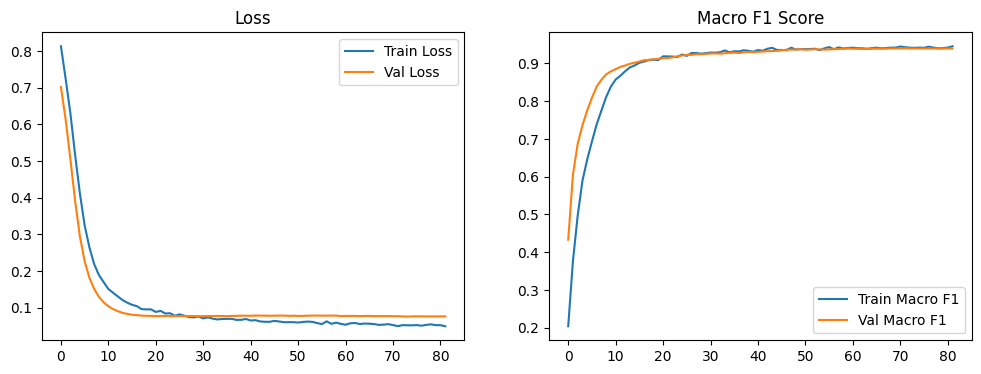

In [270]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.savefig("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Plots/training_loss.png", dpi=300, bbox_inches="tight")

plt.subplot(1, 2, 2)
plt.plot(history["train_score"], label="Train Macro F1")
plt.plot(history["val_score"], label="Val Macro F1")
plt.legend(); plt.title("Macro F1 Score")
plt.savefig("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Plots/training_score.png", dpi=300, bbox_inches="tight")
plt.show()

PRC кривая (PRC важнее ROC при дисбалансе).

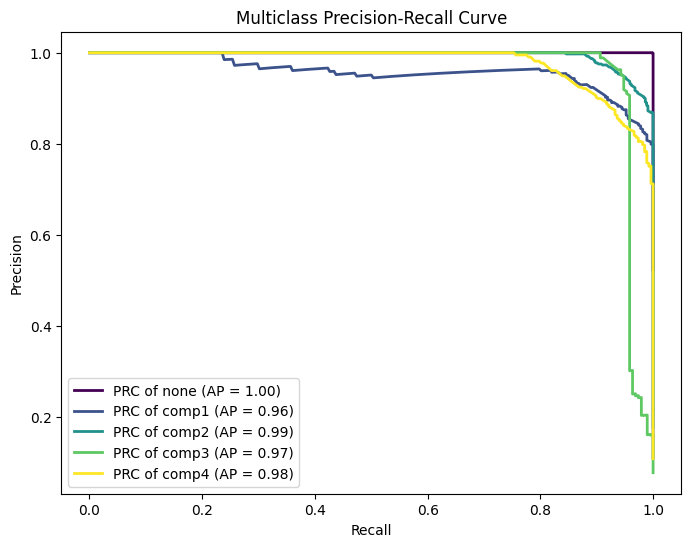

In [271]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Преобразуем y_true в one-hot
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_val_clf_t, classes=np.arange(n_classes))

# Average Precision для каждого класса
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])

# Усреднённая PRC
precision["macro"], recall["macro"], _ = precision_recall_curve(
    y_true_bin.ravel(), y_score.ravel()
)
average_precision["macro"] = average_precision_score(y_true_bin, y_score, average="macro")

# График
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'PRC of {target_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Plots//Multiclass_PRC.png", dpi=300, bbox_inches="tight")
plt.show()

Feature Importance для нейросетей (LSTM, GRU, DLinear, Transformer).

In [272]:
# from sklearn.inspection import permutation_importance

# def get_permutation_importance_pytorch(model, X_val, y_val, feature_names):
#     model.eval()
#     with torch.no_grad():
#         X_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
#         output = model(X_tensor)
#         if task == "classification":
#             y_pred_proba = torch.softmax(output, dim=1)[:, 1].cpu().numpy() 
#             baseline_score = f1_score(y_val, output.argmax(dim=1).cpu().numpy(), average='macro')
#         else:
#             y_pred_proba = output.cpu().numpy()
#             baseline_score = mean_squared_error(y_val, y_pred_proba)

#     # Перестановка
#     importances = []
#     for i in range(X_val.shape[1]):
#         X_perm = X_val.copy()
#         np.random.shuffle(X_perm[:, i])
#         with torch.no_grad():
#             X_tensor_perm = torch.tensor(X_perm, dtype=torch.float32).to(device)
#             output_perm = model(X_tensor_perm)
#             if task == "classification":
#                 score = f1_score(y_val, output_perm.argmax(dim=1).cpu().numpy(), average='macro')
#             else:
#                 score = mean_squared_error(y_val, output_perm.cpu().numpy())
#         # Для регрессии
#         importance = abs(baseline_score - score)
#         importances.append(importance)

#     return np.array(importances)

# # Применение для LSTM
# perm_importance_lstm = get_permutation_importance_pytorch(
#     lstm_model, X_val, y_val, feature_cols, task="classification"
# )

# # Визуализация
# indices = perm_importance_lstm.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(x=perm_importance_lstm[indices[:20]], y=np.array(feature_cols)[indices[:20]], palette="cubehelix")
# plt.title("Top 20 Feature Importances (LSTM, Permutation)")
# plt.xlabel("Δ F1 Score")
# plt.tight_layout()
# plt.show()

In [273]:
# GRUModel
gru_model = GRUModel(input_size, hidden_size=128, dropout=0.9).to(device)

# Обучение
y_score, history = Evaluate(gru_model, train_loader_clf, val_loader_clf, y_train=y_train, epochs=200)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_gru = np.argmax(adjusted_scores, axis=1)

# Сохранение модели Models/
model_path = "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/Multiclass/gru_model.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(gru_model.state_dict(), model_path)

Early stopping on epoch 78


In [274]:
print("GRU (Multiclass Classification):")
print(classification_report(
    y_val, 
    y_pred_gru, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val, y_pred_gru, average="macro")
print("Macro F1-score:", macro_f1)

GRU (Multiclass Classification):
              precision    recall  f1-score   support

        none       1.00      0.98      0.99      1284
       comp1       0.88      0.93      0.90       272
       comp2       0.94      0.94      0.94       435
       comp3       0.99      0.91      0.95       192
       comp4       0.86      0.93      0.90       267

    accuracy                           0.96      2450
   macro avg       0.93      0.94      0.94      2450
weighted avg       0.96      0.96      0.96      2450

Macro F1-score: 0.9351450850044255


In [275]:
# # Feature Importance для GRU
# perm_importance_gru = get_permutation_importance_pytorch(
#     gru_model, X_val, y_val, feature_cols, task="classification"
# )

# # Визуализация
# indices = perm_importance_gru.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(x=perm_importance_gru[indices[:20]], y=np.array(feature_cols)[indices[:20]], palette="cubehelix")
# plt.title("Top 20 Feature Importances (GRU, Permutation)")
# plt.xlabel("Δ F1 Score")
# plt.tight_layout()
# plt.show()

In [276]:
# DLinear с регуляризацией (нейросеть)
dlinear_model = DLinear(
    input_size=input_size,
    n_classes=5,
    dropout=0.2
).to(device)

# Обучение
y_score, history = Evaluate(dlinear_model, train_loader_clf, val_loader_clf, y_train=y_train, epochs=200)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_dl = np.argmax(adjusted_scores, axis=1)

# Сохранение модели Models/
model_path = "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/Multiclass/dlinear_model.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(dlinear_model.state_dict(), model_path)

Early stopping on epoch 166


In [277]:
print("DLinear (Multiclass Classification):")
print(classification_report(
    y_val_clf_t, 
    y_pred_dl, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred_dl, average="macro")
print("Macro F1-score:", macro_f1)

DLinear (Multiclass Classification):
              precision    recall  f1-score   support

        none       1.00      0.98      0.99      1284
       comp1       0.88      0.93      0.90       272
       comp2       0.95      0.93      0.94       435
       comp3       0.99      0.92      0.95       192
       comp4       0.82      0.94      0.88       267

    accuracy                           0.95      2450
   macro avg       0.93      0.94      0.93      2450
weighted avg       0.96      0.95      0.96      2450

Macro F1-score: 0.932322865433062


In [278]:
# # Feature Importance для DLinear
# perm_importance_dlinear = get_permutation_importance_pytorch(
#     dlinear_model, X_val, y_val, feature_cols, task="classification"
# )

# # Визуализация
# indices = perm_importance_dlinear.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(x=perm_importance_dlinear[indices[:20]], y=np.array(feature_cols)[indices[:20]], palette="cubehelix")
# plt.title("Top 20 Feature Importances (DLinear, Permutation)")
# plt.xlabel("Δ F1 Score")
# plt.tight_layout()
# plt.show()

In [290]:
# Transformer с регуляризацией (нейросеть)
transformer_model = TransformerModel(
    input_size=input_size,
    hidden_size=64,
    n_classes=5,
    dropout=0.5
).to(device)

# Обучение
y_score, history = Evaluate(transformer_model, train_loader_clf, val_loader_clf, y_train=y_train, epochs=200)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_transformer = np.argmax(adjusted_scores, axis=1)

# Сохранение модели Models/
model_path = "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/Multiclass/transformer_model.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(transformer_model.state_dict(), model_path)

Early stopping on epoch 47


In [280]:
print("Transformer (Multiclass Classification):")
print(classification_report(
    y_val_clf_t, 
    y_pred_transformer, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred_transformer, average="macro")
print("Macro F1-score:", macro_f1)

Transformer (Multiclass Classification):
              precision    recall  f1-score   support

        none       1.00      0.99      1.00      1284
       comp1       0.89      0.93      0.91       272
       comp2       0.96      0.93      0.94       435
       comp3       0.98      0.92      0.95       192
       comp4       0.87      0.94      0.90       267

    accuracy                           0.96      2450
   macro avg       0.94      0.94      0.94      2450
weighted avg       0.96      0.96      0.96      2450

Macro F1-score: 0.938976465244328


In [281]:
# # Feature Importance для Transformer
# perm_importance_transformer = get_permutation_importance_pytorch(
#     transformer_model, X_val, y_val, feature_cols, task="classification"
# )

# # Визуализация
# indices = perm_importance_transformer.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(
#     x=np.abs(perm_importance_transformer[indices[:20]]), 
#     y=np.array(feature_cols)[indices[:20]],
#     palette="cubehelix"
# )
# plt.title("Top 20 Feature Importances (Transformer, Permutation)")
# plt.xlabel("Δ F1 Score")
# plt.tight_layout()
# plt.show()

In [282]:
# Random Forest с балансировкой классов
rf_balanced = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_balanced.fit(X_train_clf_t, y_train_clf_t)

# Предсказание вероятностей
y_score = rf_balanced.predict_proba(X_val_clf_t)  # (N, 5)

# Оценка
target_names = ["none", "comp1", "comp2", "comp3", "comp4"]
labels = [0, 1, 2, 3, 4]

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Финальное предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_rf = np.argmax(adjusted_scores, axis=1)

# Сохранение модели Models/
model_path = "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/Multiclass/rf_balanced.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(rf_balanced, model_path)

['/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/Multiclass/rf_balanced.pth']

In [283]:
print("Random Forest (Balanced):")
print(classification_report(y_val_clf_t, y_pred_rf, target_names=target_names))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred_rf, average="macro")
print("Macro F1-score:", macro_f1)

Random Forest (Balanced):
              precision    recall  f1-score   support

        none       1.00      1.00      1.00      1284
       comp1       0.90      0.96      0.93       272
       comp2       0.96      0.93      0.95       435
       comp3       0.99      0.91      0.95       192
       comp4       0.89      0.93      0.91       267

    accuracy                           0.97      2450
   macro avg       0.95      0.95      0.95      2450
weighted avg       0.97      0.97      0.97      2450

Macro F1-score: 0.9460641323196086


In [284]:
# # Feature Importance для деревьев
# importances = rf_balanced.feature_importances_
# feature_names = np.array(feature_cols)

# # Сортировка
# indices = importances.argsort()[::-1]

# # Визуализация
# plt.figure(figsize=(10, 6))
# sns.barplot(x=importances[indices[:20]], y=feature_names[indices[:20]], palette="viridis")
# plt.title("Top 20 Feature Importances (Random Forest)")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()

In [285]:
# Вычисление весов для каждого примера
sample_weights = compute_sample_weight(
    class_weight="balanced",
    y=y_train  
)

# GradientBoostingClassifier с балансировкой через sample_weight
gbc_balanced = GradientBoostingClassifier(
    n_estimators=200,
    random_state=42,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2
)
gbc_balanced.fit(X_train_clf_t, y_train_clf_t)

# Предсказание вероятностей
y_score = gbc_balanced.predict_proba(X_val_clf_t)  # (N, 5)

# Настройка порогов под F2-score 
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2,
            zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Финальное предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_gbc = np.argmax(adjusted_scores, axis=1)

# Сохранение модели Models/
model_path = "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/Multiclass/gbc_balanced.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(gbc_balanced, model_path)

['/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/Multiclass/gbc_balanced.pth']

In [286]:
print("GradientBoosting (Balanced):")
print(classification_report(y_val, y_pred_gbc, target_names=target_names, labels=labels, zero_division=0))

macro_f1_gbc = f1_score(y_val, y_pred_gbc, average="macro")
print("Macro F1-score:", macro_f1_gbc)

GradientBoosting (Balanced):
              precision    recall  f1-score   support

        none       1.00      1.00      1.00      1284
       comp1       0.91      0.94      0.93       272
       comp2       0.96      0.93      0.94       435
       comp3       0.99      0.92      0.95       192
       comp4       0.88      0.93      0.90       267

    accuracy                           0.97      2450
   macro avg       0.95      0.94      0.95      2450
weighted avg       0.97      0.97      0.97      2450

Macro F1-score: 0.945015499770261


In [287]:
# # Feature Importance для градиента
# importances = gbc_balanced.feature_importances_
# feature_names = np.array(feature_cols)

# # Сортировка
# indices = importances.argsort()[::-1]

# # Визуализация
# plt.figure(figsize=(10, 6))
# sns.barplot(x=importances[indices[:20]], y=feature_names[indices[:20]], palette="viridis")
# plt.title("Top 20 Feature Importances (Gradient Boosting)")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()

In [288]:
# Все предсказания в словарь
all_models = {
    "Random Forest": y_pred_rf,  
    "Gradient Boosting": y_pred_gbc, 
    "LSTM": y_pred_lstm, 
    "GRU": y_pred_gru, 
    "DLinear": y_pred_dl, 
    "Transformer": y_pred_transformer, 
}

print("Comparison of All Models (Macro F1):")
for name, pred in all_models.items():
    f1 = f1_score(y_val, pred, average="macro")
    print(f"{name:20}: {f1:.4f}")

Comparison of All Models (Macro F1):
Random Forest       : 0.9461
Gradient Boosting   : 0.9450
LSTM                : 0.9324
GRU                 : 0.9351
DLinear             : 0.9323
Transformer         : 0.9390


Почему не ARIMA?

ARIMA was tested but showed inferior performance compared to deep learning models due to its linearity and inability to capture multivariate dependencies.

Примечание: 

ARIMA/SARIMA представляют собой одномерные модели, предназначенные для прогнозирования одного временного ряда, тогда как здесь данные многопеременные – включают несколько сенсоров (volt, rotate, pressure, vibration), ошибки, замены компонентов, возраст оборудования и категориальные признаки модели машины. 

Поведение оборудования перед отказом часто нелинейно (например, резкий рост vibration + падение pressure), тогда как ARIMA предполагает линейную зависимость во времени. 

ARIMA не способна напрямую использовать внешние регрессоры (exogenous variables) в полной мере, особенно в случае с разнородными, нестационарными и категориальными данными (machine model, age, error counts, days since last replacement). 